In [142]:
import glob
import pathlib

import xarray
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
from sklearn.linear_model import ElasticNet, Ridge, RidgeCV, BayesianRidge, ARDRegression, LinearRegression, Lasso
from sklearn.kernel_ridge import KernelRidge
import sunpy.map

from mocksipipeline.util import stack_components
from overlappy.io import read_overlappogram
from overlappy.util import color_lat_lon_axes

## Load Simulated Overlappograms

In [7]:
data_dir = pathlib.Path('../pipeline/data')
lf_files = sorted((data_dir / 'p0.005' / 'overlappograms/').glob('*.fits'), key=lambda x: int(x.name.split('.')[0].split('_o')[-1]))
hf_files = sorted((data_dir / 'p0.3' / 'overlappograms/').glob('*.fits'), key=lambda x: int(x.name.split('.')[0].split('_o')[-1]))

In [9]:
observing_interval = 3600 * u.s

In [10]:
simulated_overlappogram_hf = stack_components([read_overlappogram(f) for f in hf_files], wcs_index=4) / observing_interval / (1*u.pix)
simulated_overlappogram_lf = stack_components([read_overlappogram(f) for f in lf_files], wcs_index=4) / observing_interval / (1*u.pix)

In [11]:
norm = ImageNormalize(vmin=1e-4, vmax=1, stretch=LogStretch())
plot_opts = {
    'norm': norm,
    'data_unit': 'ct / pix / s',
    'cmap': 'viridis',
    'interpolation': 'none',
}

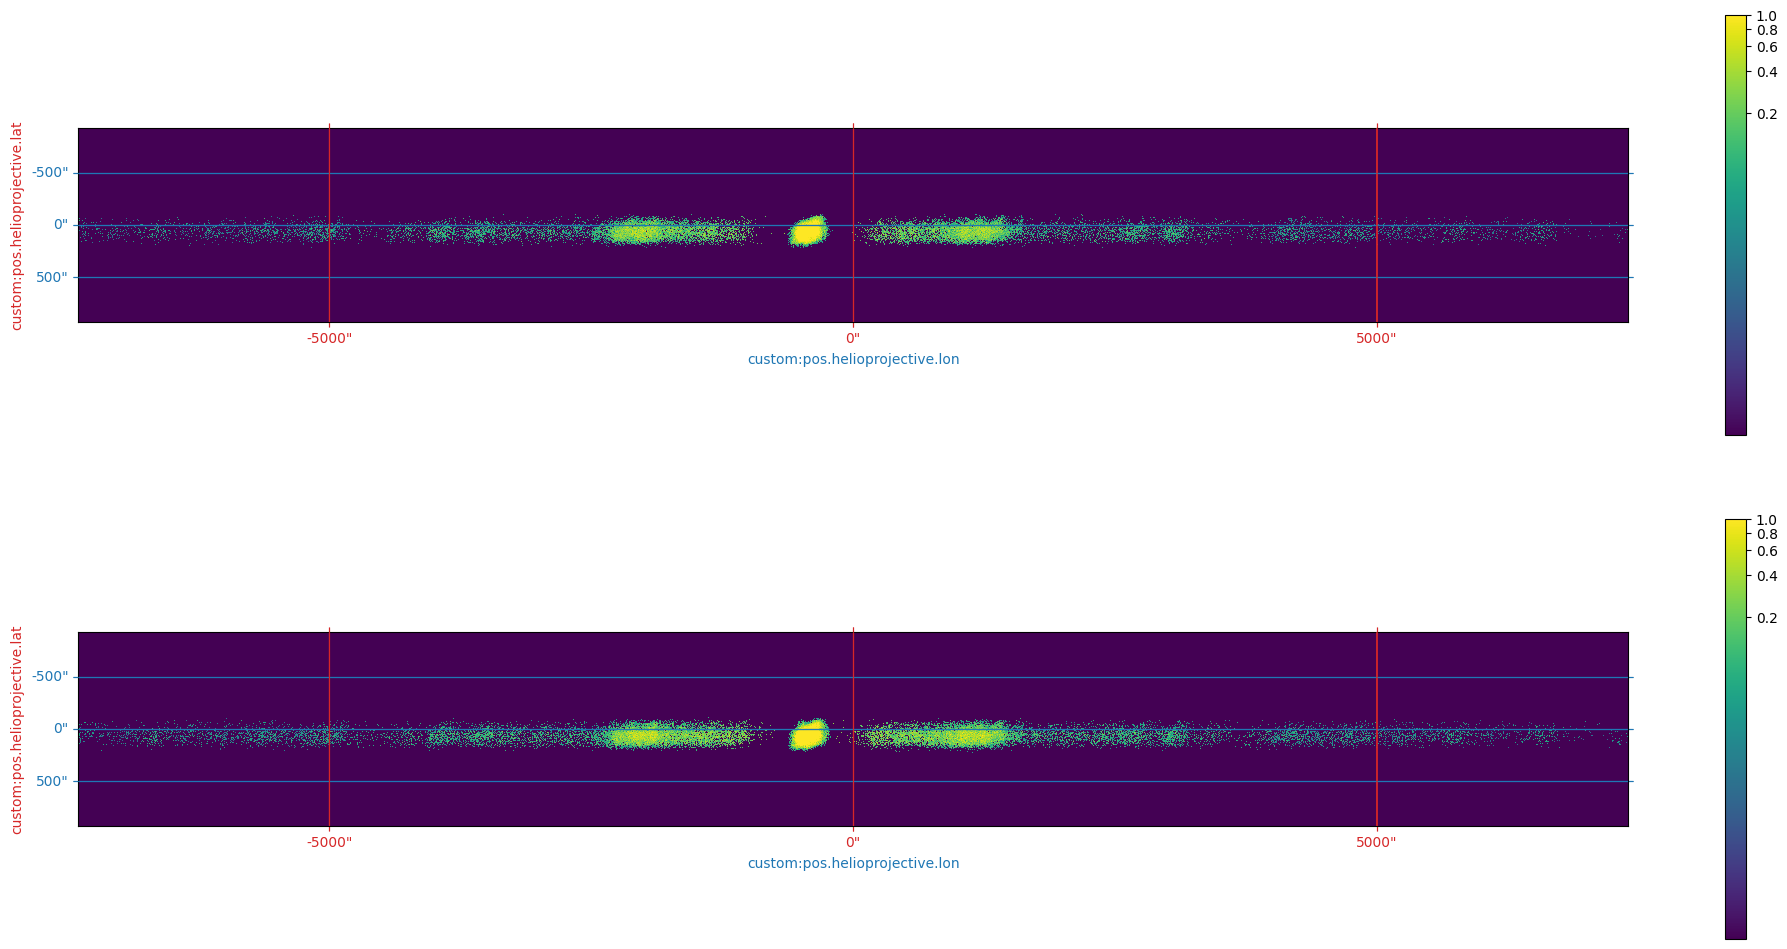

In [15]:
fig = plt.figure(figsize=(25,12))
sl = np.s_[0, 250:500, :]
ax = fig.add_subplot(2,1,1,projection=simulated_overlappogram_hf[sl].wcs)
simulated_overlappogram_hf[sl].plot(axes=ax, **plot_opts)
color_lat_lon_axes(ax)
plt.colorbar()
ax = fig.add_subplot(2,1,2,projection=simulated_overlappogram_lf[sl].wcs)
simulated_overlappogram_lf[sl].plot(axes=ax, **plot_opts)
color_lat_lon_axes(ax)
plt.colorbar()

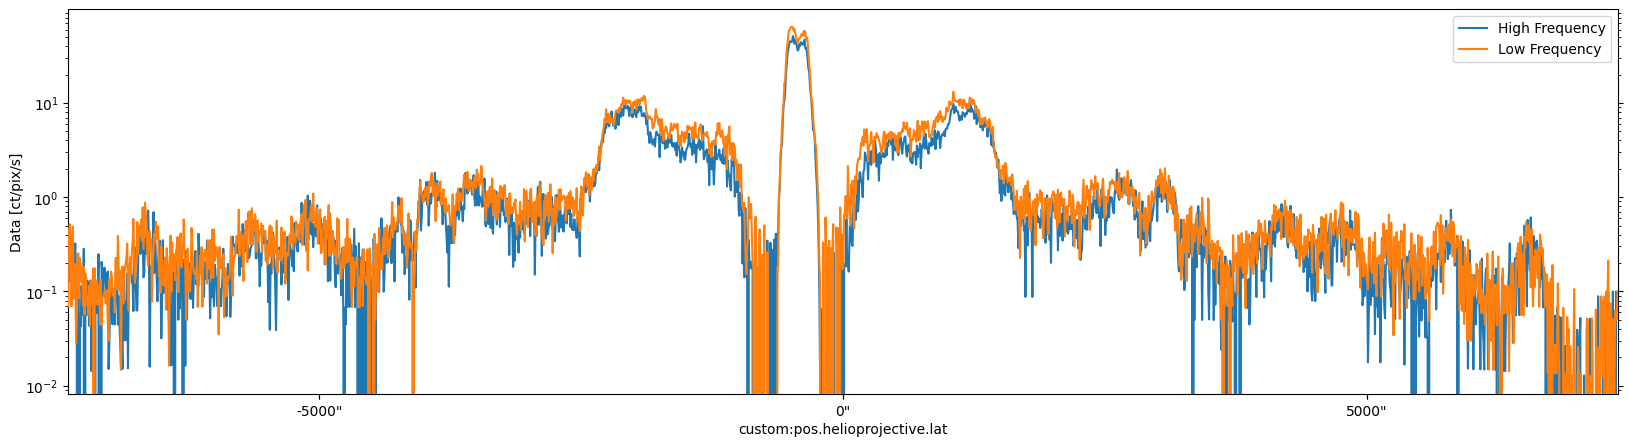

In [16]:
fig = plt.figure(figsize=(20,5))
summed_hf = simulated_overlappogram_hf[sl].rebin(simulated_overlappogram_hf[sl].data.shape[:1]+(1,), operation=np.sum)[0]
ax = fig.add_subplot(projection=summed_hf.wcs)
summed_hf.plot(axes=ax, label='High Frequency', data_unit='ct/pix/s')
summed_lf = simulated_overlappogram_lf[sl].rebin(simulated_overlappogram_lf[sl].data.shape[:1]+(1,), operation=np.sum)[0]
summed_lf.plot(axes=ax, label='Low Frequency', data_unit='ct/pix/s')
ax.set_yscale('log')
ax.set_xlim(0,2000)
ax.legend()

## Transform to `xarray.DataArray`

In [17]:
simulated_overlappogram_xa = xarray.Dataset({
    'hf': xarray.DataArray(
            simulated_overlappogram_hf[0].data,
            dims=['pixel_y', 'pixel_detector'],
            attrs={
                'unit': simulated_overlappogram_hf.unit.to_string(format='fits'),
            },
            name='simulated_moxsi_counts'
    ),
    'lf': xarray.DataArray(
            simulated_overlappogram_lf[0].data,
            dims=['pixel_y', 'pixel_detector'],
            attrs={
                'unit': simulated_overlappogram_lf.unit.to_string(format='fits'),
            },
            name='simulated_moxsi_counts'
    ),
})

In [18]:
simulated_overlappogram_xa

<xarray.Dataset>
Dimensions:  (pixel_y: 750, pixel_detector: 2000)
Dimensions without coordinates: pixel_y, pixel_detector
Data variables:
    hf       (pixel_y, pixel_detector) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lf       (pixel_y, pixel_detector) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

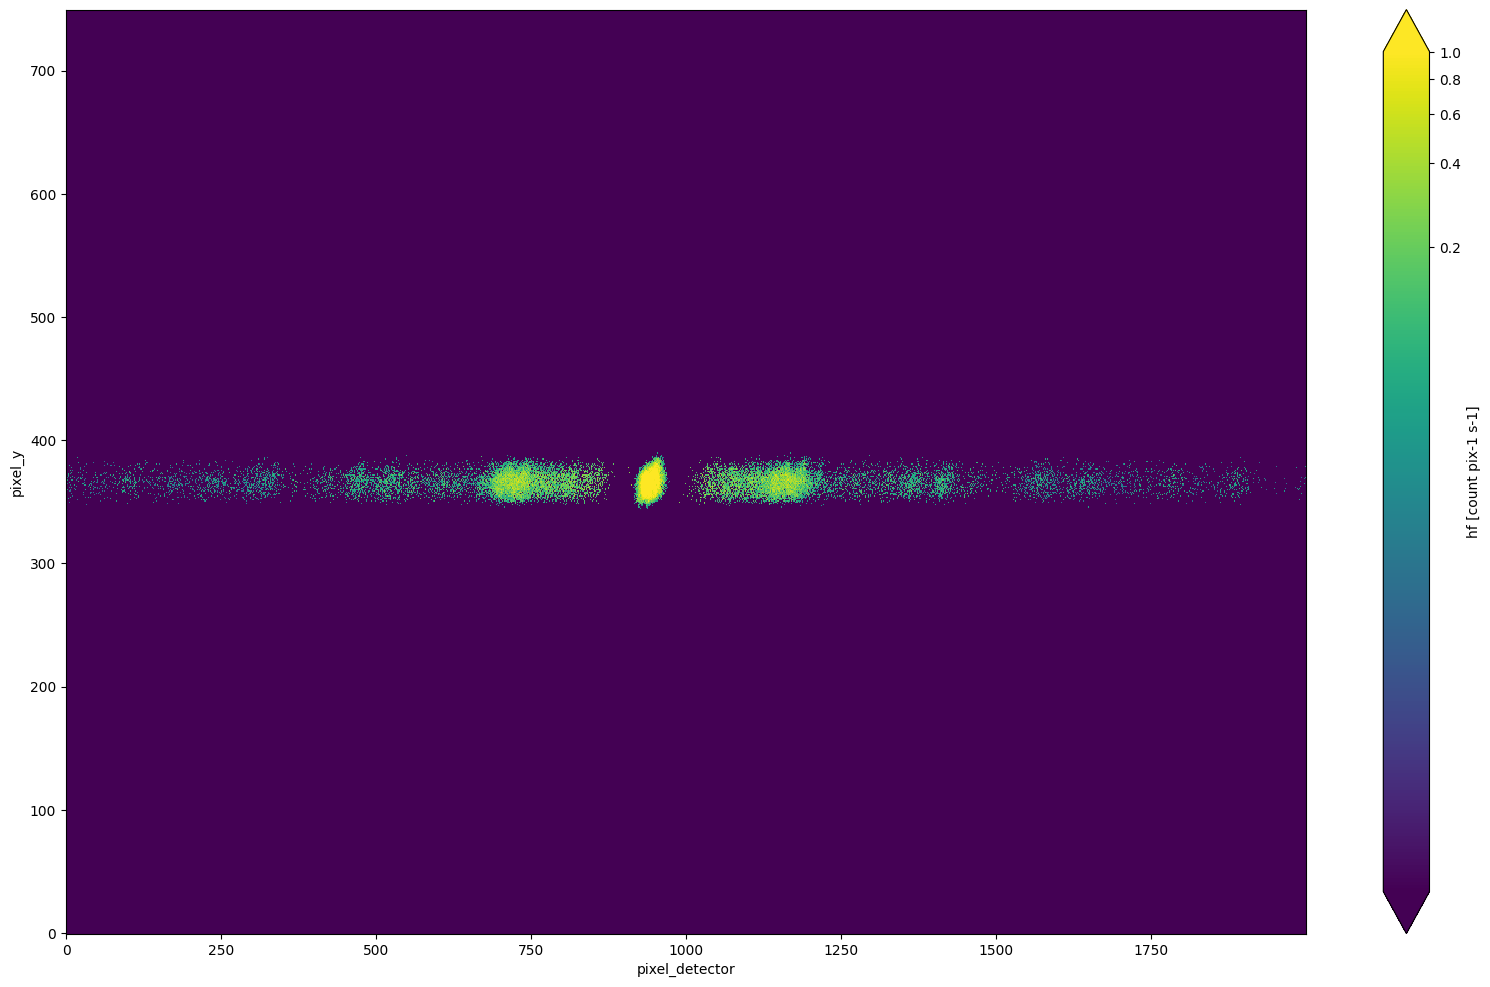

In [19]:
plt.figure(figsize=(20,12))
simulated_overlappogram_xa['hf'].plot.imshow(norm=norm)

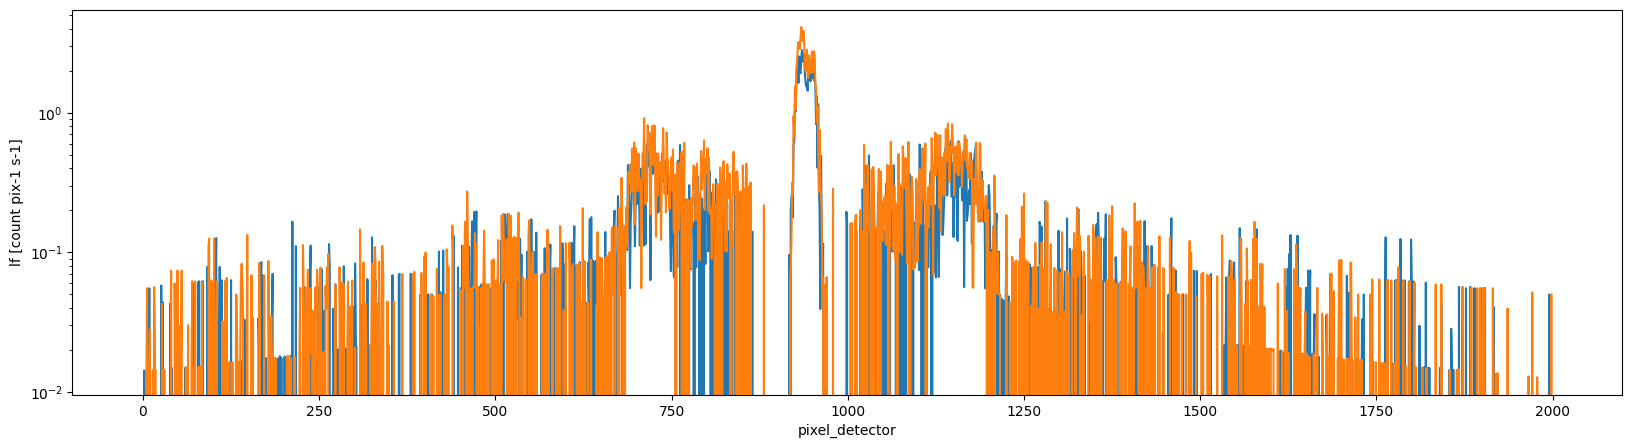

In [20]:
plt.figure(figsize=(20,5))
simulated_overlappogram_xa['hf'][365,:].plot()
simulated_overlappogram_xa['lf'][365,:].plot()
plt.yscale('log')

## Load Model DEMs

In [21]:
dem_data_dir = pathlib.Path('/Users/wtbarnes/Documents/presentations/sphere-workshop-2023-talk/pipeline/data/')

In [22]:
def load_average_em_cube(data_dir, p, n_time=3600):
    # set up initial array
    m_dem_seq = sunpy.map.Map(sorted((dem_data_dir / f'p{p}'/ 'dem').glob('m_*_t0.fits')), sequence=True)
    total_dem = np.zeros(m_dem_seq.as_array().shape)
    # set up temperature bins
    temperature_bin_edges = np.unique(np.array([m.meta['instrume'].split('_')[2].split('-') for m in m_dem_seq]).astype(float).flatten())
    temperature_bin_centers = (temperature_bin_edges[:-1] + temperature_bin_edges[1:])/2
    # iterate over all timesteps
    for i in range(n_time):
        _seq = sunpy.map.Map(sorted((dem_data_dir / f'p{p}'/ 'dem').glob(f'm_*_t{i}.fits')), sequence=True)
        total_dem += _seq.as_array()
    # return as xarray
    all_coords = sunpy.map.all_coordinates_from_map(m_dem_seq[0])
    return xarray.DataArray(
        total_dem/n_time,
        dims=['pixel_y', 'pixel_x', 'log_temperature'],
        coords={
            'log_temperature': temperature_bin_centers,
            'hpc_longitude': (['pixel_y', 'pixel_x'], all_coords.Tx.to_value('arcsec')),
            'hpc_latitude': (['pixel_y', 'pixel_x'], all_coords.Ty.to_value('arcsec')),
        },
        attrs={
            'bunit': 'cm-5',
            'p': p,
            **m_dem_seq[0].meta,
        },
        name='simulated_dem'
    )

In [23]:
em_true_lf = load_average_em_cube(dem_data_dir, 0.005, n_time=3600)

In [24]:
em_true_hf = load_average_em_cube(dem_data_dir, 0.3, n_time=3600)

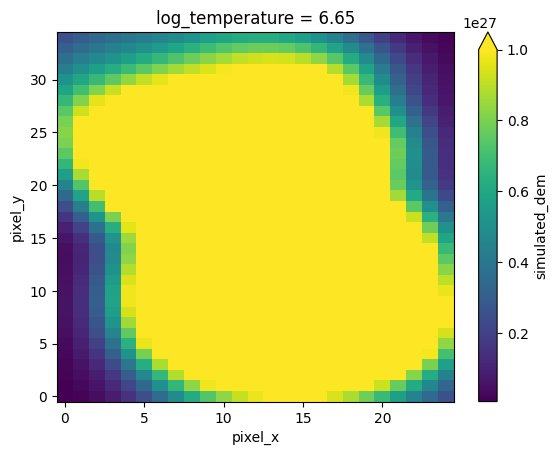

In [44]:
em_true_hf[15:50,15:40,11].plot(vmax=1e27)

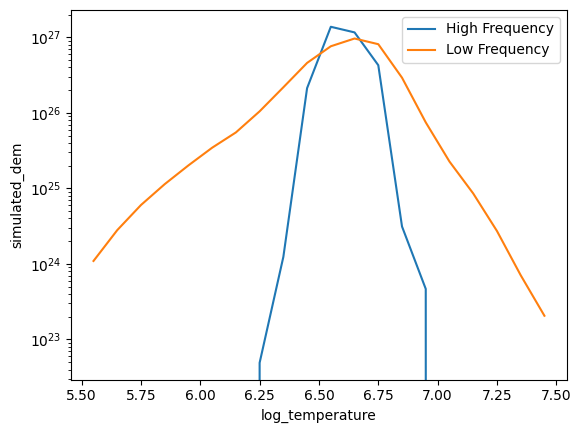

In [45]:
em_true_hf[15:50,15:40,:].mean(dim=['pixel_y', 'pixel_x']).plot(label='High Frequency')
em_true_lf[15:50,15:40,:].mean(dim=['pixel_y', 'pixel_x']).plot(label='Low Frequency')
plt.yscale('log')
plt.legend()

## Load Response Function

In [47]:
response_matrix = xarray.open_dataarray('../../../projects/cubixss/moxsi-science-planning/sandbox/moxsi_response_matrix.nc')
response_matrix_total = response_matrix.sum(dim='spectral_order').rename({'pixel_fov': 'pixel_x'})
response_matrix_total = response_matrix_total.interp(
    log_temperature=em_true_hf.log_temperature,
    method='slinear',
    kwargs={'fill_value': 0.0,
            'bounds_error': False}
)

In [48]:
response_matrix_total

<xarray.DataArray (pixel_x: 338, pixel_detector: 2000, log_temperature: 20)>
array([[[1.15726913e-34, 2.44440425e-34, 4.20177738e-34, ...,
         5.34180174e-33, 4.22293443e-33, 4.02579255e-33],
        [1.22528320e-34, 3.35166682e-34, 1.29387374e-33, ...,
         5.31672096e-33, 4.24132934e-33, 4.05288736e-33],
        [1.16568136e-34, 2.52280730e-34, 4.74865909e-34, ...,
         5.61362587e-33, 4.49582726e-33, 4.24911277e-33],
        ...,
        [1.75983788e-34, 1.42441374e-33, 5.17811851e-33, ...,
         5.00227302e-34, 4.72876390e-34, 4.50826744e-34],
        [3.21551207e-34, 2.69299429e-33, 9.80190417e-33, ...,
         4.56530176e-34, 4.43067677e-34, 4.29137188e-34],
        [1.68678086e-34, 4.19021717e-34, 5.31103630e-34, ...,
         4.44243754e-34, 4.34321135e-34, 4.22800454e-34]],

       [[1.15805199e-34, 2.60428472e-34, 7.46790786e-34, ...,
         5.36768996e-33, 4.19551572e-33, 3.99546296e-33],
        [1.15726913e-34, 2.44440425e-34, 4.20177738e-34, ...,
         5.34180174e-33, 4.22293443e-33, 4.02579255e-33],
        [1.22528320e-34, 3.35166682e-34, 1.29387374e-33, ...,
         5.31672096e-33, 4.24132934e-33, 4.05288736e-33],
...
        [1.22528320e-34, 3.35166682e-34, 1.29387374e-33, ...,
         5.31672096e-33, 4.24132934e-33, 4.05288736e-33],
        [1.15726913e-34, 2.44440425e-34, 4.20177738e-34, ...,
         5.34180174e-33, 4.22293443e-33, 4.02579255e-33],
        [1.15805199e-34, 2.60428472e-34, 7.46790786e-34, ...,
         5.36768996e-33, 4.19551572e-33, 3.99546296e-33]],

       [[1.68678086e-34, 4.19021717e-34, 5.31103630e-34, ...,
         4.44243754e-34, 4.34321135e-34, 4.22800454e-34],
        [3.21551207e-34, 2.69299429e-33, 9.80190417e-33, ...,
         4.56530176e-34, 4.43067677e-34, 4.29137188e-34],
        [1.75983788e-34, 1.42441374e-33, 5.17811851e-33, ...,
         5.00227302e-34, 4.72876390e-34, 4.50826744e-34],
        ...,
        [1.16568136e-34, 2.52280730e-34, 4.74865909e-34, ...,
         5.61362587e-33, 4.49582726e-33, 4.24911277e-33],
        [1.22528320e-34, 3.35166682e-34, 1.29387374e-33, ...,
         5.31672096e-33, 4.24132934e-33, 4.05288736e-33],
        [1.15726913e-34, 2.44440425e-34, 4.20177738e-34, ...,
         5.34180174e-33, 4.22293443e-33, 4.02579255e-33]]])
Coordinates:
  * log_temperature  (log_temperature) float64 5.55 5.65 5.75 ... 7.25 7.35 7.45
Dimensions without coordinates: pixel_x, pixel_detector

In [49]:
SCALING_CONSTANT = 1e30

## FOV Selection

The following calculations carefully select both the parts of the response matrix as well as the portion of the spectrum. This is done carefully because we are averaging over the whole relevant FOV and a lot of the FOV contains zeros. To avoid averaging too many zeros, we select only the parts of the FOV that correspond to the simulated FOV.

Construct a FOV that corresponds to the zeroth order component and only the emitting part.

In [61]:
total_extent = 2500 * u.arcsec
frame = wcs_to_celestial_frame(simulated_overlappogram_hf.wcs)
bottom_left = SkyCoord(Tx=-total_extent/2,Ty=-total_extent/2, frame=frame)
top_right = SkyCoord(Tx=bottom_left.Tx+total_extent, Ty=bottom_left.Ty+total_extent, frame=frame)
spatial_fov = simulated_overlappogram_hf[0,...].crop(bottom_left, top_right)

Now, get the FOV of the original simulated map

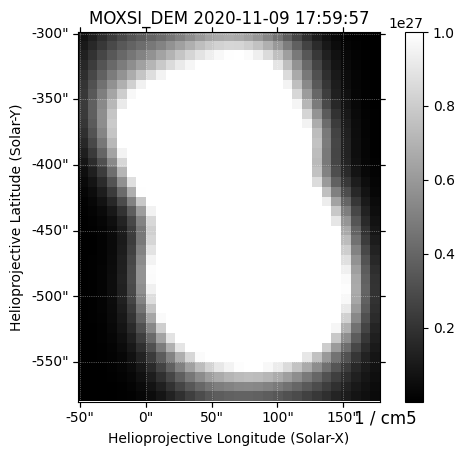

In [74]:
m_dem_sim = sunpy.map.Map(dem_data_dir / 'p0.3' / 'dem' / 'm_6.60-6.70_t1800.fits')
blc_core = SkyCoord(Tx=-50*u.arcsec, Ty=-575*u.arcsec, frame=m_dem_sim.coordinate_frame)
trc_core = SkyCoord(Tx=175*u.arcsec, Ty=-300*u.arcsec, frame=m_dem_sim.coordinate_frame)
m_dem_sim.submap(blc_core,top_right=trc_core).peek(vmax=1e27)

In [83]:
i_y_min_dem_sim, i_x_min_dem_sim = m_dem_sim.wcs.world_to_array_index(blc_core)
i_y_max_dem_sim, i_x_max_dem_sim = m_dem_sim.wcs.world_to_array_index(trc_core)
i_y_max_dem_sim += 1
i_x_max_dem_sim += 1

And map that to the zeroth order FOV. This tells us the extent in the spatial dimension that overlaps with the spectral dimension (FOV).

In [79]:
iy_bl, ix_bl = spatial_fov.wcs.world_to_array_index(blc_core)
iy_tr, ix_tr = spatial_fov.wcs.world_to_array_index(trc_core)

In [80]:
i_fov_min = min(ix_bl, ix_tr)
i_fov_max = max(ix_bl, ix_tr) + 1  # inclusive of this pixel

Now, map this to the overlapped WCs. This tells us the extent in the non-dispersed direction over which there is emission

In [81]:
iy_bl, ix_bl = simulated_overlappogram_hf[0].wcs.world_to_array_index(blc_core)
iy_tr, ix_tr = simulated_overlappogram_hf[0].wcs.world_to_array_index(trc_core)

In [82]:
i_y_min = min(iy_tr, iy_bl)
i_y_max = max(iy_tr, iy_bl) + 1  # inclusive of this pixel

## Inversion

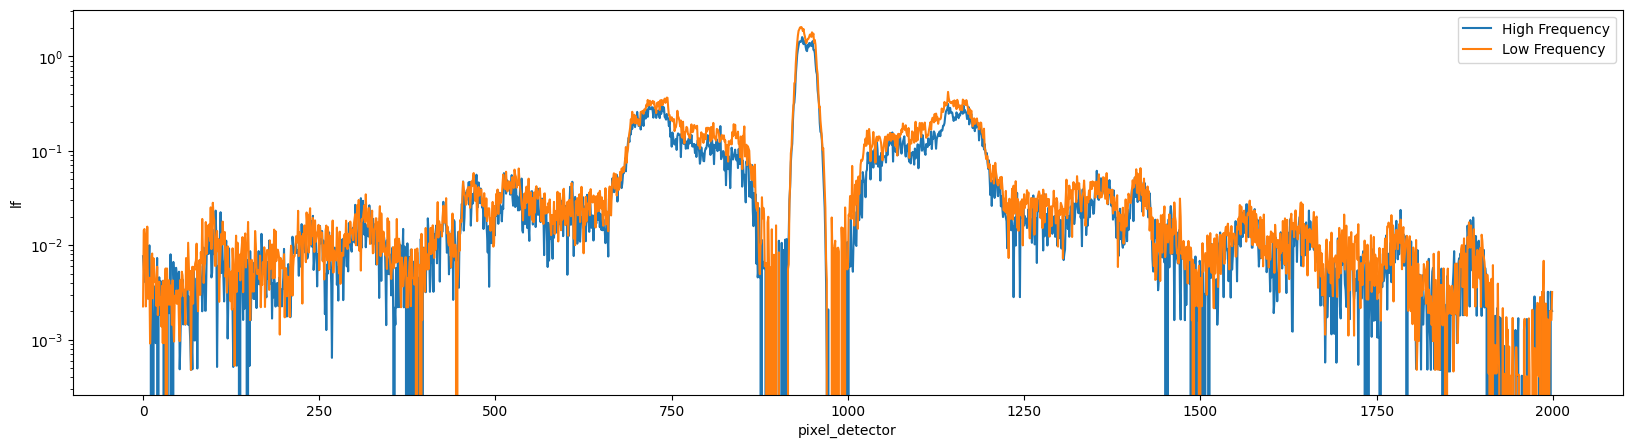

In [84]:
plt.figure(figsize=(20,5))
simulated_overlappogram_xa['hf'][i_y_min:i_y_max,:].mean(dim='pixel_y',).plot(label='High Frequency')
simulated_overlappogram_xa['lf'][i_y_min:i_y_max,:].mean(dim='pixel_y',).plot(label='Low Frequency')
plt.yscale('log')
plt.legend()

In [85]:
def fit_spectra(response, spectra, scaling, model, plot_spectra_comparison=True,):
    """
    Fit spectra and visually assess goodness of fit.
    
    Parameters
    ----------
    """
    x_ = response.stack(pixel_logT=('pixel_x', 'log_temperature'))
    clf = model.fit(x_.values*scaling, spectra.values, )
    em_coefficients = xarray.DataArray(
        clf.coef_,
        dims=['pixel_logT'],
        coords={'pixel_logT': x_.pixel_logT},
    )*scaling
    recovered_spectra = x_.dot(em_coefficients, dims=['pixel_logT'])
    if plot_spectra_comparison:
        plt.figure(figsize=(25,5))
        spectra.plot(label='data')
        recovered_spectra.plot(label='recovered')
        plt.yscale('log')
        plt.legend()
        plt.show()
    print(model.score(x_.values*scaling, spectra.values))
    return em_coefficients.unstack(), recovered_spectra

In [994]:
#model = ElasticNet(
#    positive=True,
#    alpha=2,
#    l1_ratio=0,
#    max_iter=5000,
#    fit_intercept=True,
#)
model = Ridge(
    alpha=1.5,
    fit_intercept=True,
    positive=True,
)
#model = LinearRegression(
#    positive=True,
#    fit_intercept=True,
#)
#model=None
#model = BayesianRidge(
#    fit_intercept=False,
#    alpha_1=1,
#    alpha_2=10,
#    lambda_1=1,
#    lambda_2=10,
#    compute_score=True,
#    tol=1e-4,
#    alpha_init=10.0,
#    lambda_init=1.0,
#)
#model = ARDRegression()

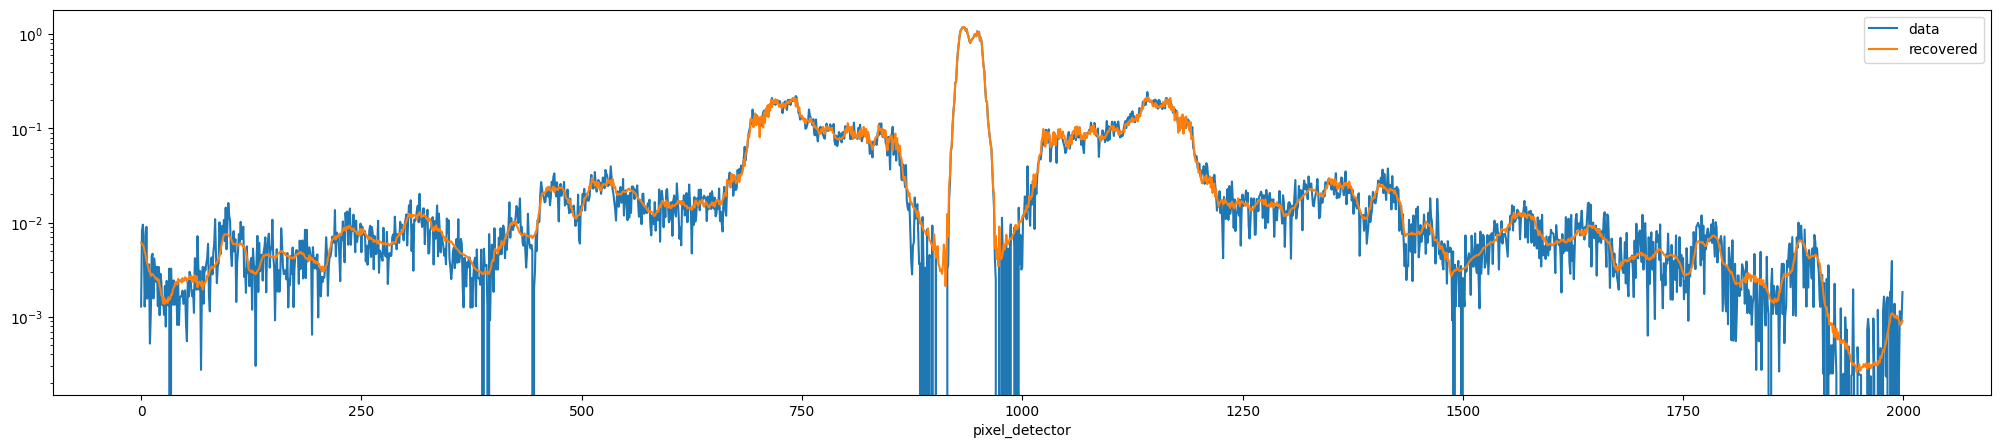

In [995]:
em_recovered_lf, spectra_recovered_lf = fit_spectra(response_matrix_total[i_fov_min:i_fov_max,:,...],
                                                    simulated_overlappogram_xa['lf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',),
                                                    SCALING_CONSTANT,
                                                    model)

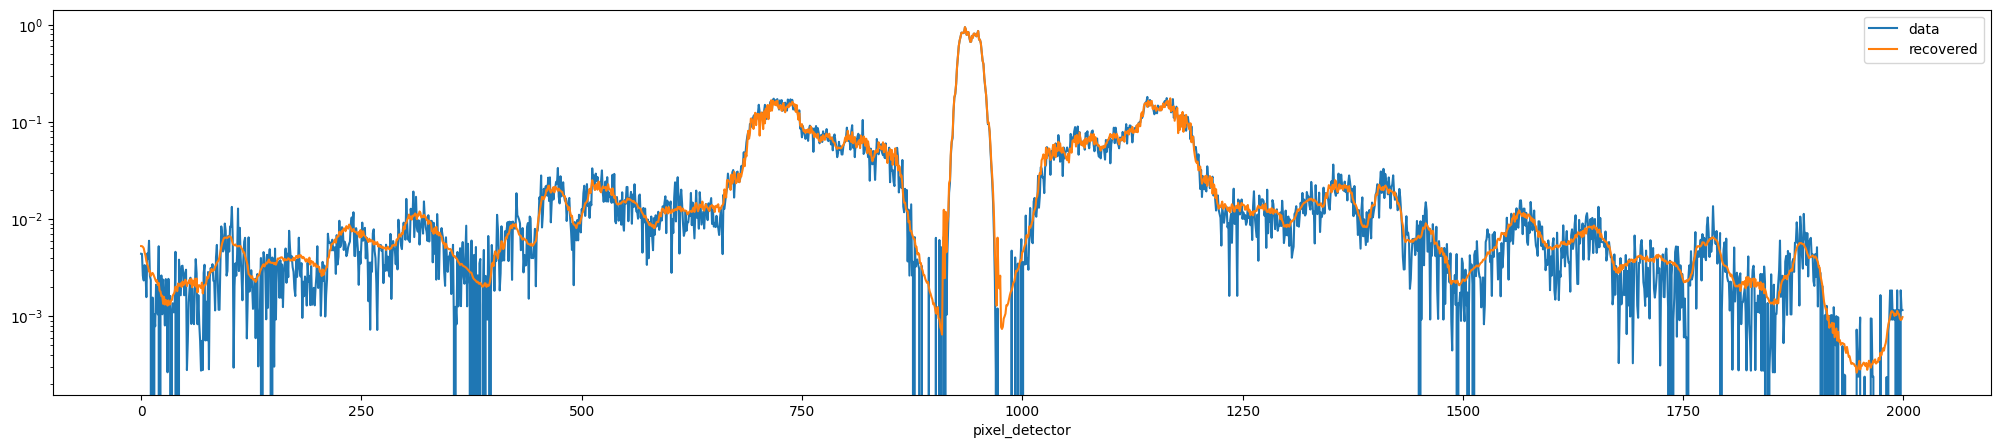

In [996]:
em_recovered_hf, spectra_recovered_hf = fit_spectra(response_matrix_total[i_fov_min:i_fov_max,:,...],
                                                    simulated_overlappogram_xa['hf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',),
                                                    SCALING_CONSTANT,
                                                    model)

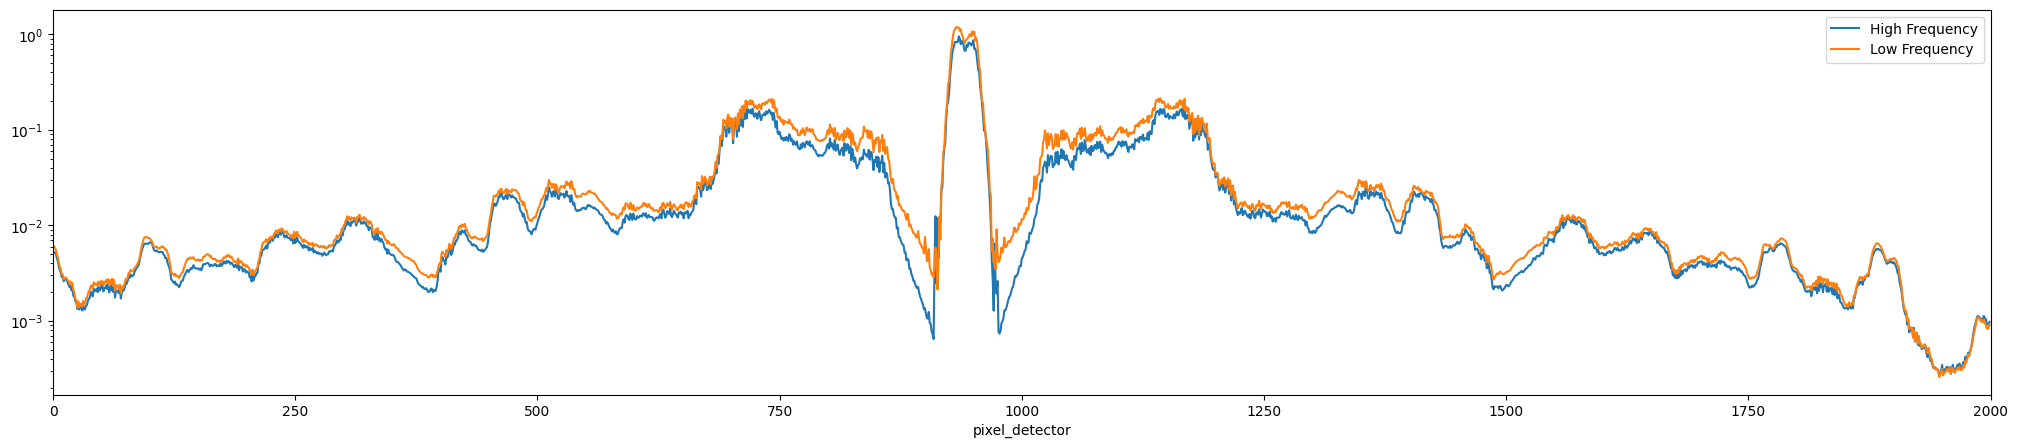

In [997]:
plt.figure(figsize=(25,5))
spectra_recovered_hf.plot(label='High Frequency')
spectra_recovered_lf.plot(label='Low Frequency')
plt.yscale('log')
plt.xlim(0,2000)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


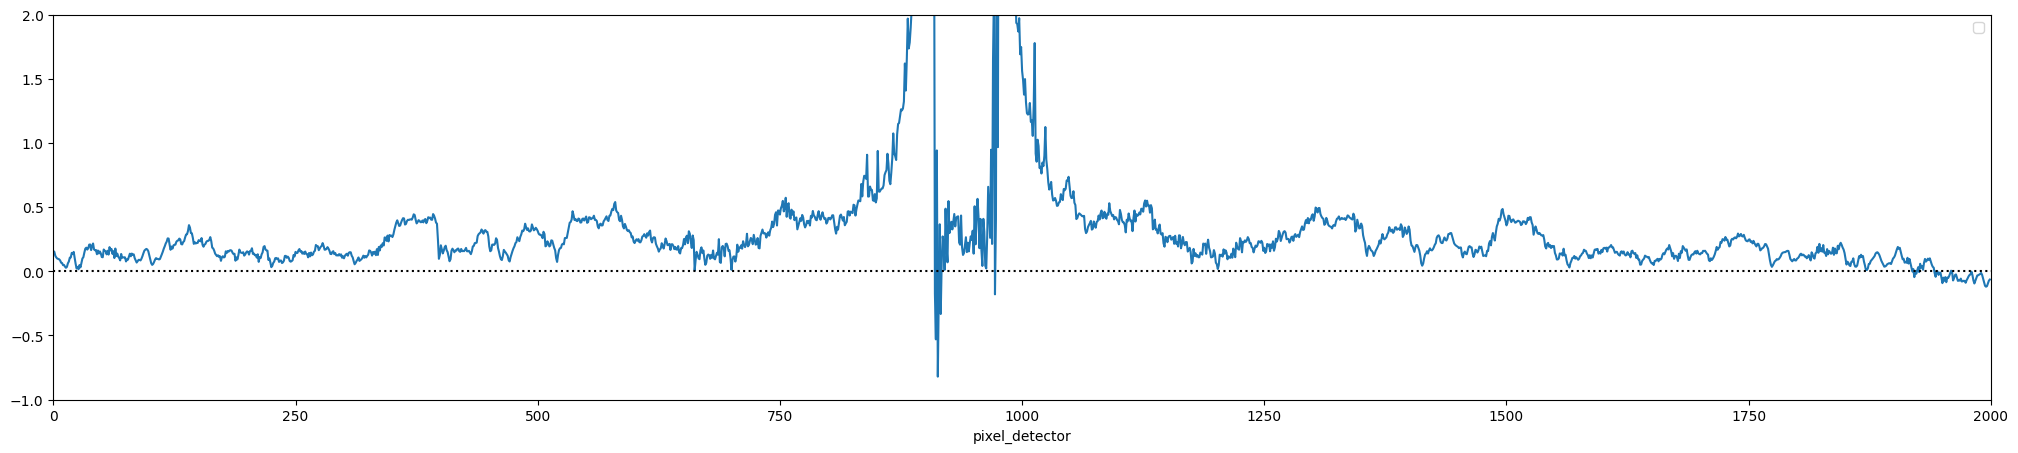

In [998]:
plt.figure(figsize=(25,5))
(spectra_recovered_lf / spectra_recovered_hf - 1).plot()
#plt.yscale('log')
plt.axhline(y=0, color='k', ls=':')
plt.xlim(0,2000)
plt.ylim(-1,2)
plt.legend()

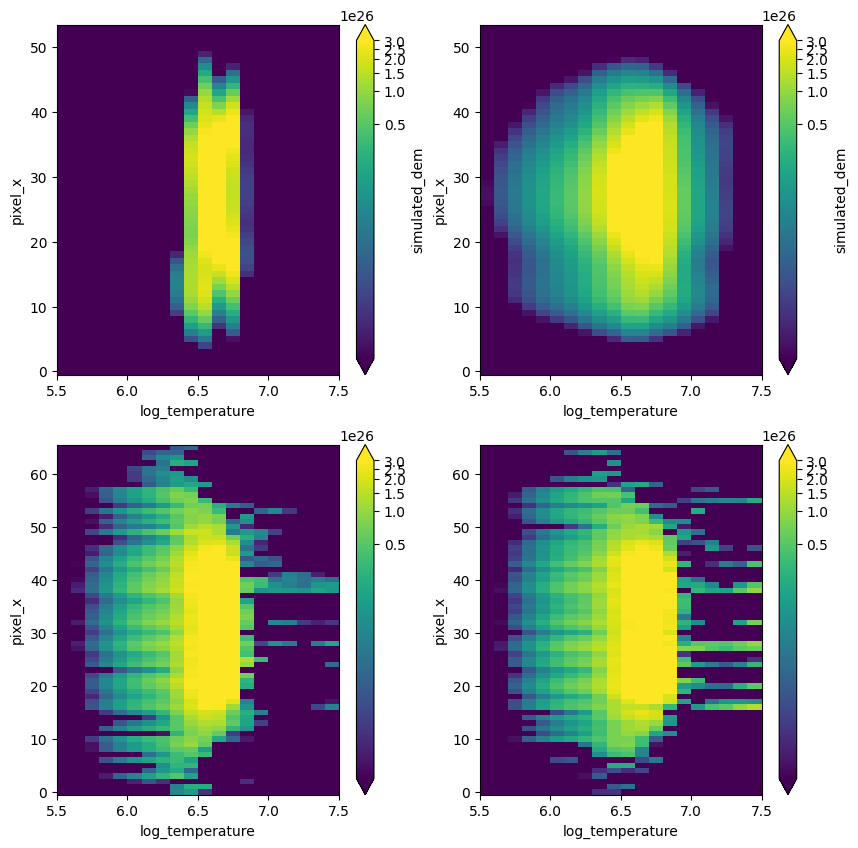

In [999]:
norm = ImageNormalize(vmin=1e24, vmax=3e26, stretch=LogStretch())
plt.figure(figsize=(10,10))
plt.subplot(221)
em_true_hf.mean(dim=['pixel_y']).plot(norm=norm)
plt.subplot(222)
em_true_lf.mean(dim=['pixel_y']).plot(norm=norm)
plt.subplot(223)
em_recovered_hf.plot(norm=norm)
plt.subplot(224)
em_recovered_lf.plot(norm=norm)

Now compare to the model DEMs

In [1]:
em_true_hf.mean(dim=['pixel_y', 'pixel_x']).plot(label='HF, true', color='C0', ls='--')
em_true_lf.mean(dim=['pixel_y', 'pixel_x']).plot(label='LF, true', color='C1', ls='--')
#em_recovered_hf.mean(dim='pixel_x').coarsen(log_temperature=2).sum().plot(label='HF, recovered', color='C0', ls='-')
#em_recovered_lf.mean(dim='pixel_x').coarsen(log_temperature=2).sum().plot(label='LF, recovered', color='C1', ls='-')
em_recovered_hf.mean(dim='pixel_x').plot(label='HF, recovered', color='C0', ls='-')
em_recovered_lf.mean(dim='pixel_x').plot(label='LF, recovered', color='C1', ls='-')
plt.yscale('log')
#plt.xlim(5.5,7.5)
plt.ylim(1e24,5e26)
plt.legend()

NameError: name 'em_true_hf' is not defined

0.9964340901977807
0.9951239939281282
0.9964297078128265
0.9951240248364112
0.9964292934029158
0.9951239873765159
0.9961873456657008
0.9951238819421668
0.9964502767640869
0.9949579642325963
0.9961851202719902
0.9950509384434562
0.9962250222768005
0.9950622016518784
0.996184515689225
0.994989755652566
0.9961670254582287
0.995022947870758


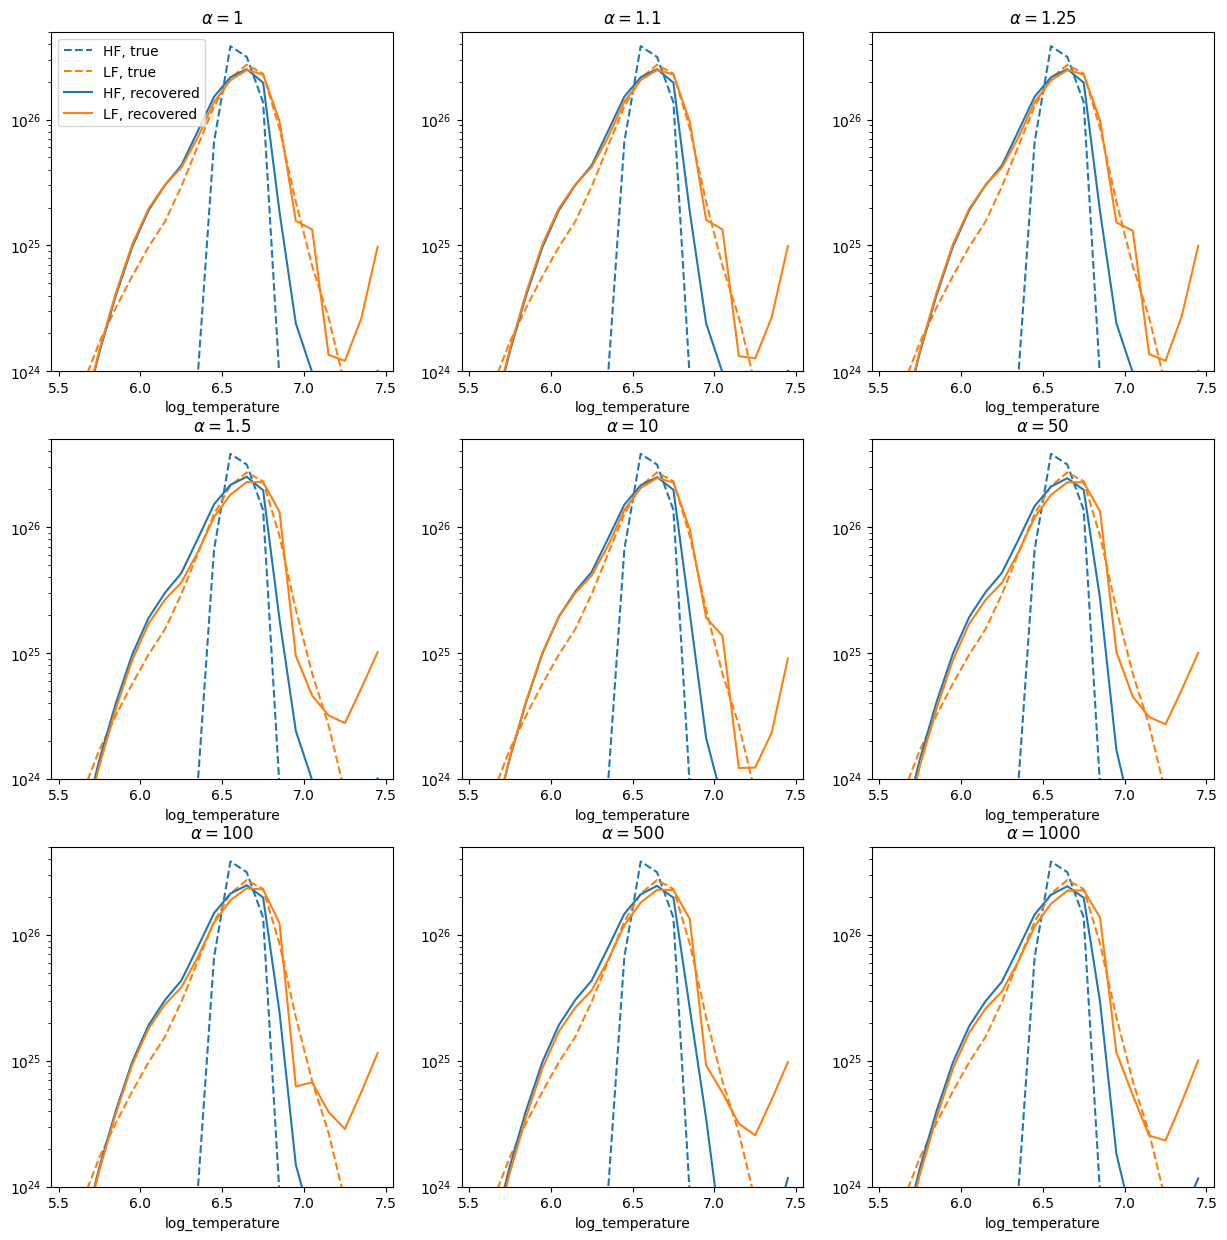

In [1017]:
spec_lf = simulated_overlappogram_xa['lf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',)
spec_hf = simulated_overlappogram_xa['hf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',)
resp_matrix = response_matrix_total[i_fov_min:i_fov_max,:,...]
alphas = [1, 1.1, 1.25, 1.5, 10, 50, 100, 500, 1000]
recovered_ems = []
for alpha in alphas:
    model = Ridge(
        alpha=alpha,
        fit_intercept=True,
        positive=True,
    )
    em_recovered_lf, _ = fit_spectra(resp_matrix, spec_lf, SCALING_CONSTANT, model, plot_spectra_comparison=False)
    em_recovered_hf, _ = fit_spectra(resp_matrix, spec_hf, SCALING_CONSTANT, model, plot_spectra_comparison=False)
    recovered_ems.append((em_recovered_hf, em_recovered_lf))
    
    
fig = plt.figure(figsize=(15,15))
for i,(alpha,(emr_hf,emr_lf)) in enumerate(zip(alphas, recovered_ems)):
    ax = fig.add_subplot(3,3,i+1)
    em_true_hf.mean(dim=['pixel_y', 'pixel_x']).plot(label='HF, true', color='C0', ls='--')
    em_true_lf.mean(dim=['pixel_y', 'pixel_x']).plot(label='LF, true', color='C1', ls='--')
    emr_hf.mean(dim='pixel_x').plot(label='HF, recovered', color='C0', ls='-')
    emr_lf.mean(dim='pixel_x').plot(label='LF, recovered', color='C1', ls='-')
    ax.set_title(r'$\alpha=$'+f'{alpha}')
    plt.yscale('log')
    plt.ylim(1e24,5e26)
    if i==0:
        plt.legend()

## Comparing Inversion Methods

In [143]:
ridge_model = Ridge(
    alpha=100,
    positive=True,
    max_iter=5000,
    fit_intercept=True
)
lasso_lars_model = Lasso(
    alpha=1e-6,
    fit_intercept=True,
    positive=True,
    max_iter=5000,
)
elasticnet_model = ElasticNet(
    positive=True,
    alpha=0.01,
    l1_ratio=1e-5,
    max_iter=5000,
    fit_intercept=True,
)

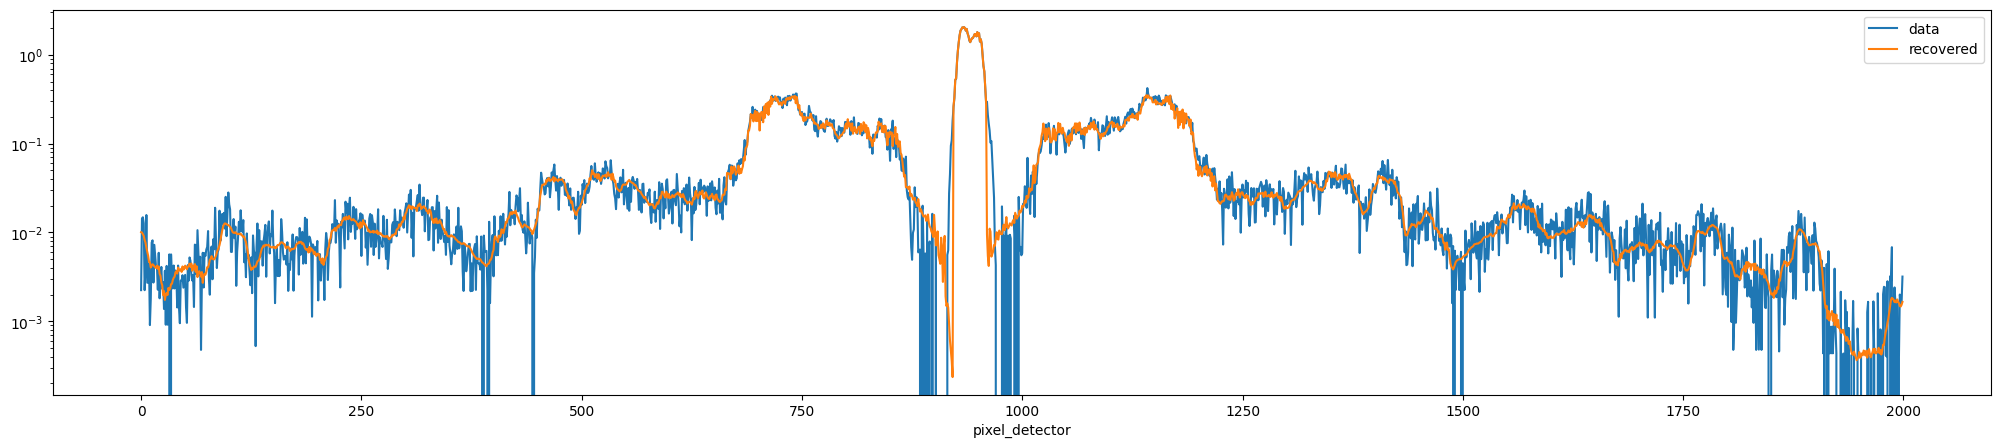

0.9933320601749599


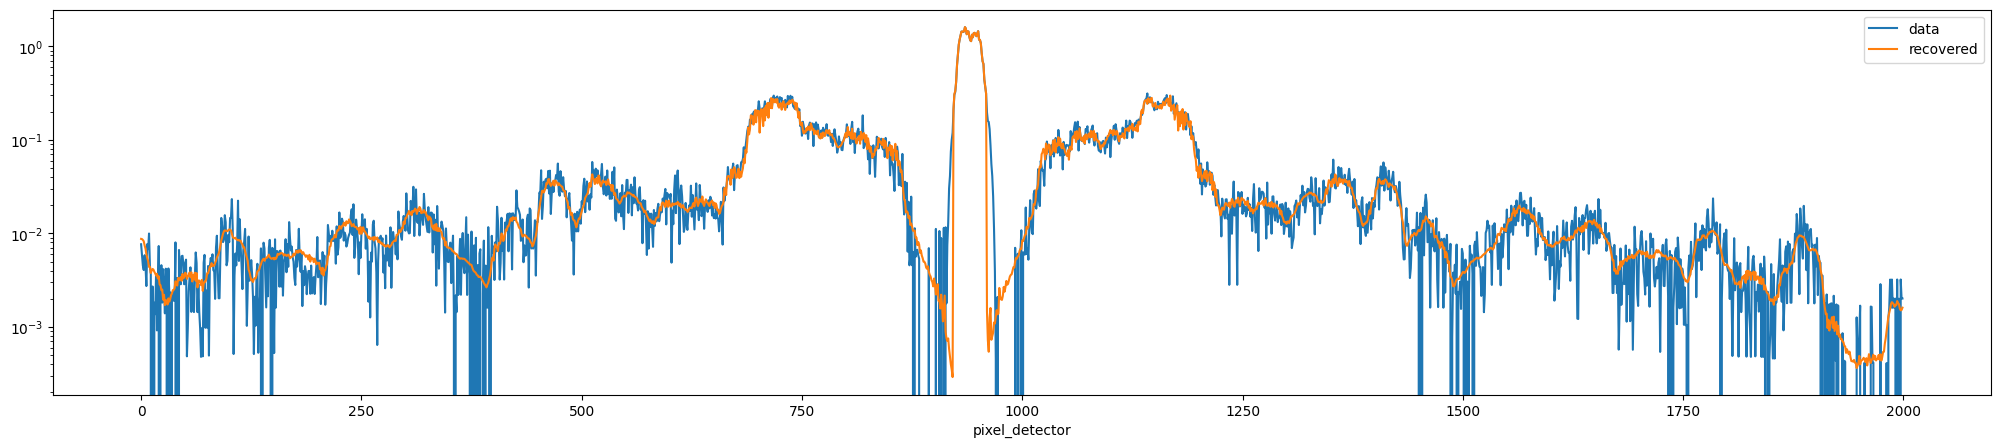

0.9919614129907598


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.493e-01, tolerance: 8.816e-03
  model = cd_fast.enet_coordinate_descent(


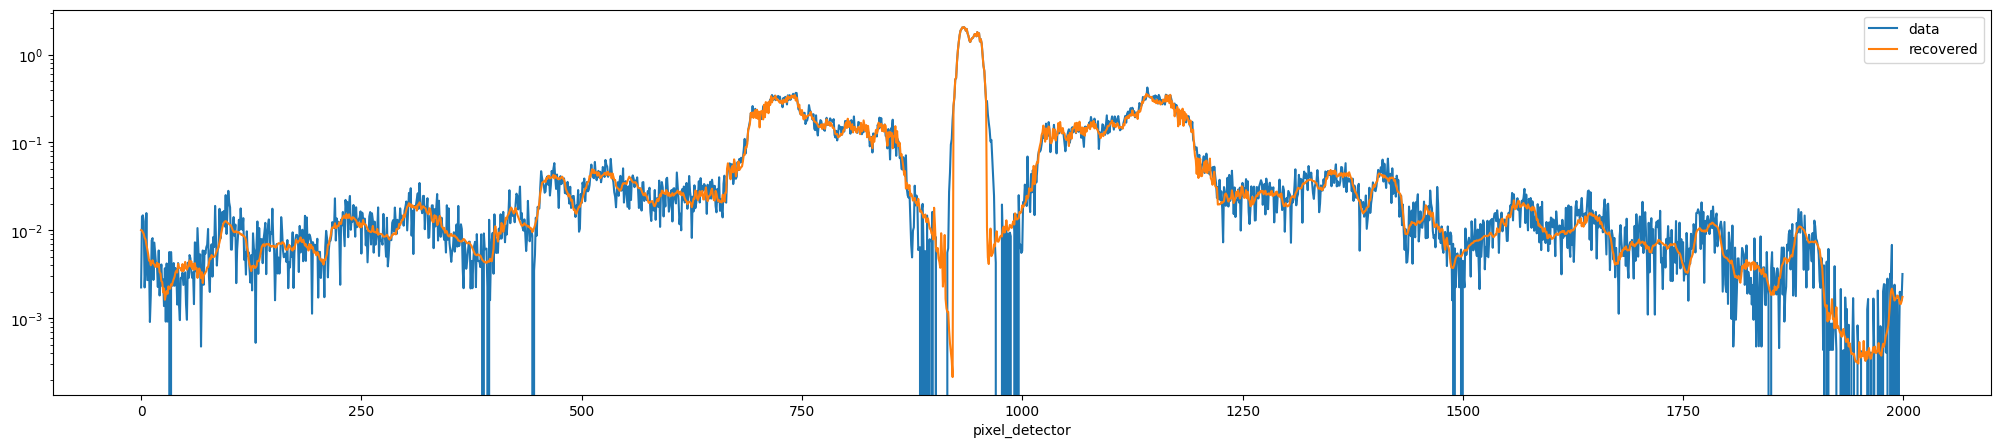

0.9937011505780232


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 5.306e-03
  model = cd_fast.enet_coordinate_descent(


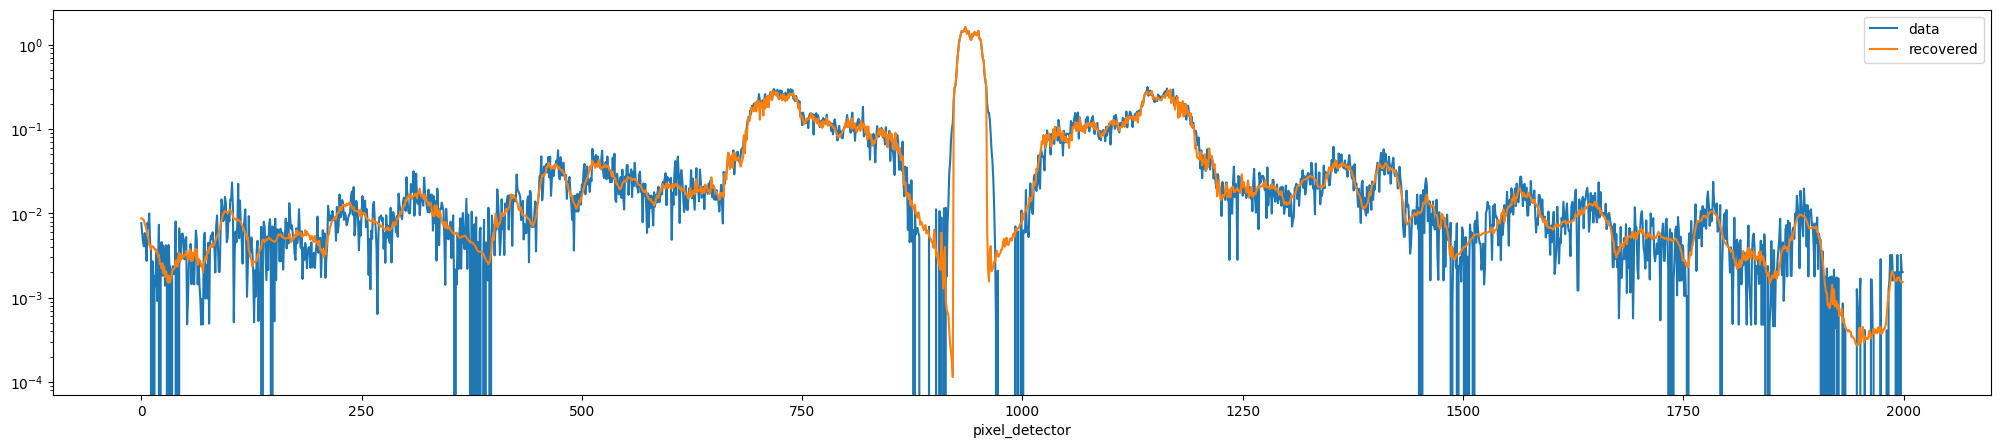

0.992679778539114


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e-01, tolerance: 8.816e-03
  model = cd_fast.enet_coordinate_descent(


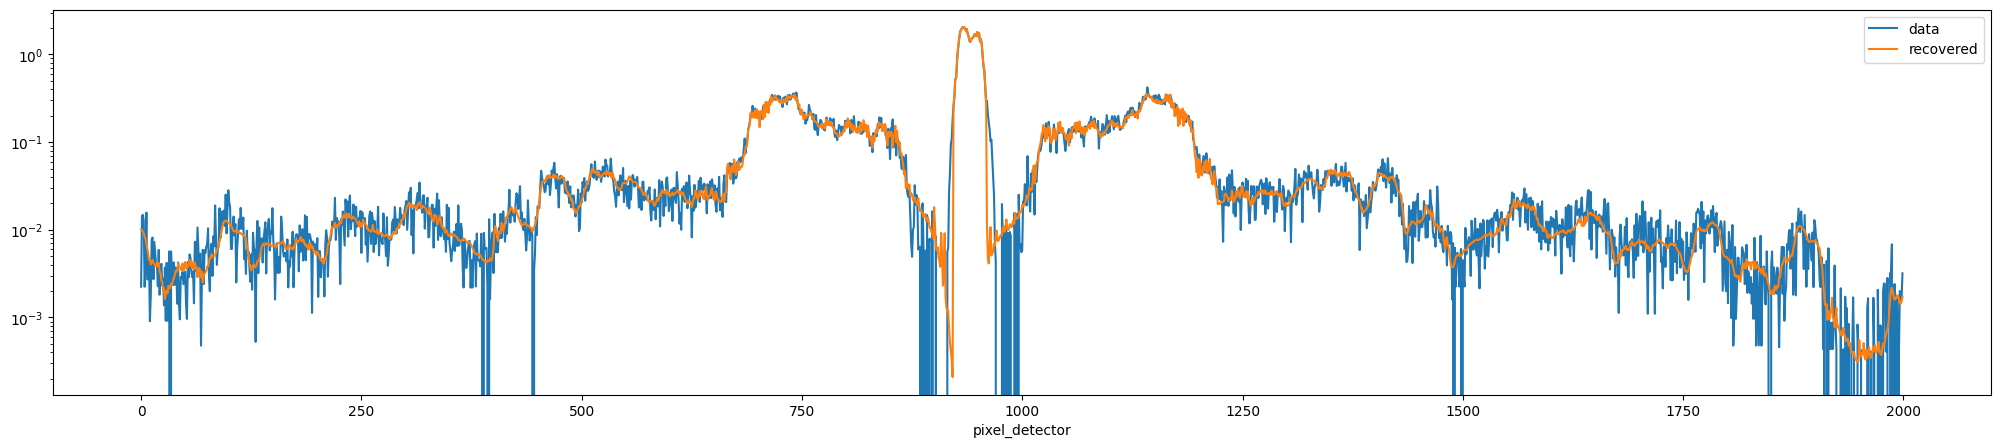

0.9936987239789935


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 5.306e-03
  model = cd_fast.enet_coordinate_descent(


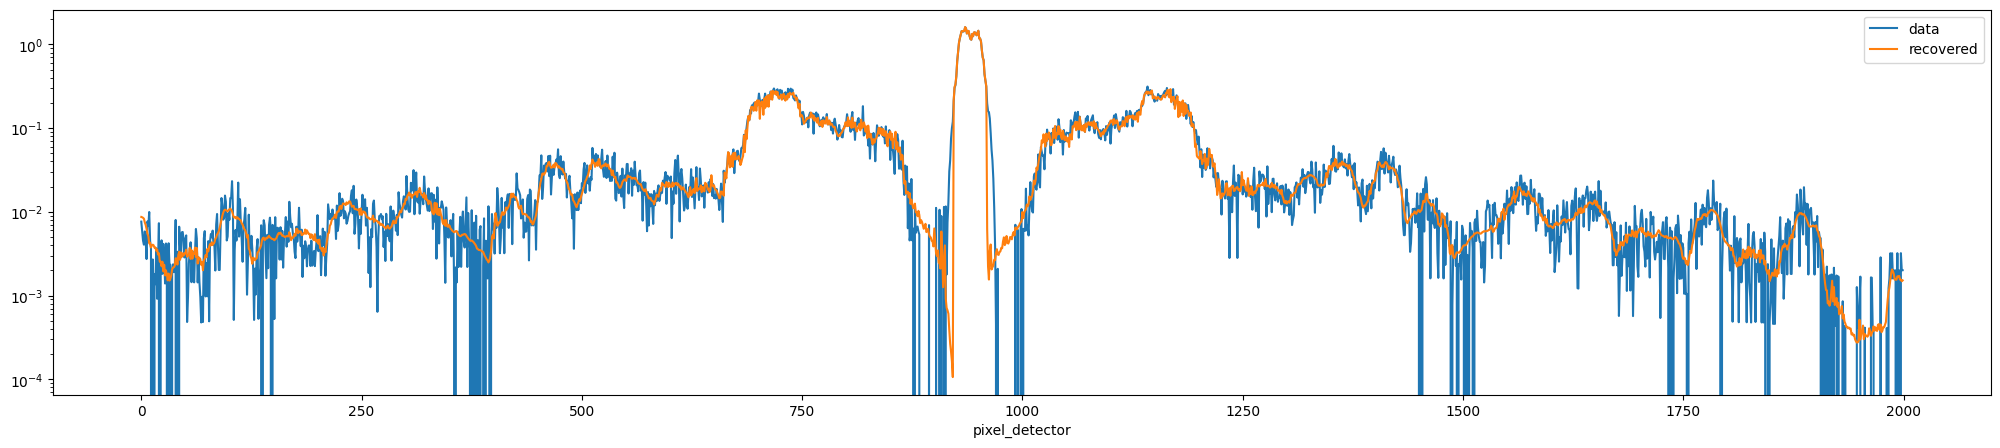

0.9926719304541571


In [144]:
spec_lf = simulated_overlappogram_xa['lf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',)
spec_hf = simulated_overlappogram_xa['hf'][i_y_min:i_y_max,:,...].mean(dim='pixel_y',)
resp_matrix = response_matrix_total[i_fov_min:i_fov_max,:,...]
recovered_ems = {}
for name, model in [('Ridge', ridge_model), ('Lasso', lasso_lars_model), ('ElasticNet', elasticnet_model)]:
    em_recovered_lf, _ = fit_spectra(resp_matrix, spec_lf, SCALING_CONSTANT, model, plot_spectra_comparison=True)
    em_recovered_hf, _ = fit_spectra(resp_matrix, spec_hf, SCALING_CONSTANT, model, plot_spectra_comparison=True)
    recovered_ems[name] = (em_recovered_hf, em_recovered_lf)

In [145]:
import wesanderson
frequency_palette = wesanderson.color_palettes['The French Dispatch'][0][2:]

In [146]:
import matplotlib

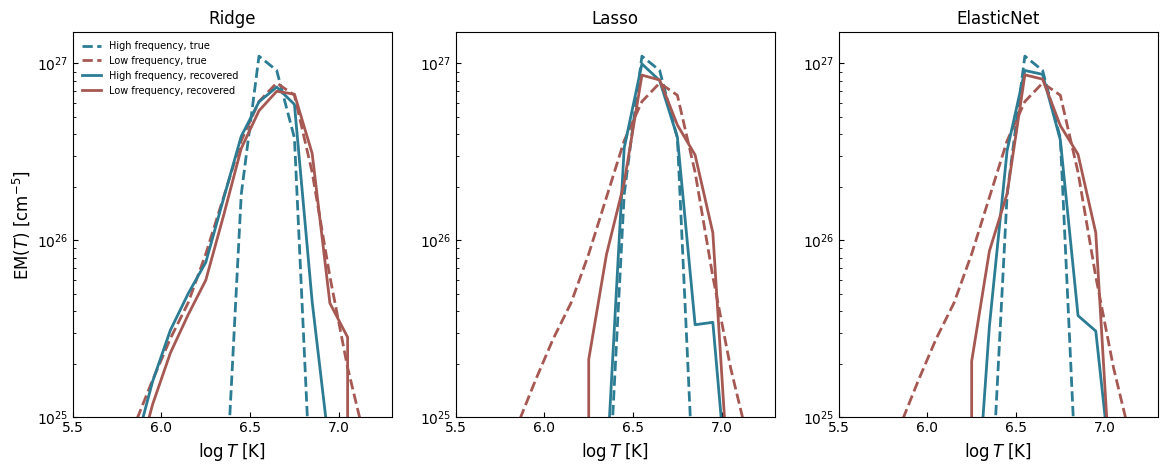

In [147]:
with matplotlib.rc_context(fname='../presentation/matplotlibrc'):
    fig = plt.figure(figsize=(14,5))
    for i, (model_name, (emr_hf, emr_lf)) in enumerate(recovered_ems.items()):
        ax = fig.add_subplot(1,3,i+1)
        em_true_hf[i_y_min_dem_sim:i_y_max_dem_sim, i_x_min_dem_sim:i_x_max_dem_sim, :].mean(dim=['pixel_y', 'pixel_x']).plot(
            label='High frequency, true', color=frequency_palette[0], ls='--')
        em_true_lf[i_y_min_dem_sim:i_y_max_dem_sim, i_x_min_dem_sim:i_x_max_dem_sim, :].mean(dim=['pixel_y', 'pixel_x']).plot(
            label='Low frequency, true', color=frequency_palette[1], ls='--')
        emr_hf.mean(dim='pixel_x').plot(label='High frequency, recovered', color=frequency_palette[0], ls='-')
        emr_lf.mean(dim='pixel_x').plot(label='Low frequency, recovered', color=frequency_palette[1], ls='-')
        ax.set_title(model_name)
        ax.set_yscale('log')
        ax.set_ylim(1e25,1.5e27)
        ax.set_xlim(5.5, 7.3)
        if i==0:
            ax.legend(loc=2, frameon=False)
            ax.set_ylabel('$\mathrm{EM}(T)$ [cm$^{-5}$]')
        ax.set_xlabel('$\log{T}$ [K]')
    fig.savefig('../presentation/static/em-inverted-true-compare.png', dpi=300)